## 看中文姓名猜性別: Projects namesex and namesex_light

對一般人來說，由中文人名猜測性別有相當高的準確度。這件事由機器學習的模型來做，也可以有相當不錯的結果。在這裡介紹兩個Python的模組可以幫大家判斷中文姓名的性別傾向，就是看名子猜性別啦。

先介紹比較簡單的版本，namesex_light。可以直接使用pip install安裝，這個模組需要先安裝numpy。或者讓pip在裝namesex_light時幫你一起裝。打開你的console (bash, cmd, etc.)，然後執行 ""pip install namesex_light"應該就可以了。不過我這台測試機器是要這樣裝...

In [3]:
!pip3 install --user namesex_light

  Using cached https://files.pythonhosted.org/packages/91/18/162d8a6681c264bcfb5d84c42d399155c902f7ee63a0adc195aa1595d55a/namesex_light-0.1.6-py3-none-any.whl


先說明一下這個pip3 install中"--user"這參數是跟pip說要裝在自己家的目錄，而不是作業系統中公用的位置。會是pip3而不是pip是因為我用的這台機器 (Ubuntu 16 LTS) 有python2跟python3，然後python3的pip叫pip3。對大部分的人來說，如果你只有裝python3，那"pip install namesex_light"應該就會動了。

接下來就可以牛刀小試一下。namesex_light內建訓練好的Regularized Logistic Regression，將要預測的人名丟給predict()就好了。可以用 predprob=True 選擇輸出預測為男性的機率。預測是輸出1(男性)或0(女性)。

In [4]:
import namesex_light
nsl = namesex_light.namesex_light()
pred1 = nsl.predict(['民豪', '愛麗', '志明'])
print("Label prediction = {}".format(pred1))
pred2 = nsl.predict(['民豪', '愛麗', '志明'], predprob=True)
print("Predictions with probability = {}".format(pred2))

Label prediction = [1 0 1]
Predictions with probability = [0.99968932 0.00530066 0.9938986 ]


另一個兄弟模組，namesex，是做一樣的事，但有幾個不同的地方

* namesex依賴numpy, scipy, 與sklearn，但namesex_light只需要numpy。
* namesex有訓練好的Random Forest模型與Regularized Logistic Regression模型，而namesex_light只有Regularized Logistic Regression。
* namesex中的Random Forest模型使用的特徵包含名字本身，名子中的單字，以及單字對應的Skip-gram Word Embedding模型訓練出的一百維向量，而namesex_light沒有使用這個Skip-gram的向量。
* namesex附帶訓練資料集，namesex_light沒有附帶訓練資料集。
* namesex可以自行訓練Random Forest與Regularized Logistic Regression。namesex_light不行。

簡單的說，如果只是要一個會動的東西，那namesex_light就好了。如果要比較好的預測能力則可以選擇namesex。

要安裝namesex也是"pip install namesex"即可。不過對Windows使用者來說，最好先裝好numpy, scipy, 跟sklearn。主要的原因是大部分Windows使用者沒有C++編譯器。使用pip裝scipy很容易失敗。

在這台測試機器，安裝namesex是用pip3:

In [5]:
!pip3 install --user namesex

  Using cached https://files.pythonhosted.org/packages/45/68/ccf78426f1316a8de3adb1639189742a4d167fec47f93613c8da74236d2a/namesex-0.1.15-py3-none-any.whl


讓我們來試試namesex吧!

In [6]:
import namesex
ns = namesex.namesex()
pred3 = ns.predict(['民豪', '愛麗', '志明'])
print("Label prediction = {}".format(pred3))
pred4 = ns.predict(['民豪', '愛麗', '志明'], predprob=True)
print("Prediction probability = {}".format(pred4))

Label prediction = [1 0 1]
Prediction probability = [0.8245     0.25695238 0.85      ]


## 測試資料集的預測能力

namesex跟namesex_light都有附帶一個小型的測試資料集。這個測試資料集有102個人名與性別。這個資料集是透過作者的朋友圈收集而來，因此可以確定正確的性別標記。另外，這個測試資料集並沒有用在模型訓練，因此可以當成是一個客觀的預測能力衡量指標。

先來看一下這個資料集的內容

In [7]:
testdata = namesex.testdata()
print("First 10 names: {}".format(testdata.gname[0:10]))
print("First 10 sex labels: {}".format(testdata.sex[0:10]))

First 10 names: ['翊如', '妤庭', '諆璋', '大閎', '和維', '宏文', '侑穎', '冠旻', '皜', '子霖']
First 10 sex labels: [0, 0, 1, 1, 1, 1, 0, 1, 1, 1]


接下來來看看幾個方法的預測能力:

In [8]:
#namesex
predb1 = ns.predict(testdata.gname)
predb2 = ns.predict_logic(testdata.gname)
#namesex_light
predb3 = nsl.predict(testdata.gname)
#compute accuracy
import numpy as np
accuracy = np.mean(predb1 == testdata.sex)
accuracy2 = np.mean(predb2 == testdata.sex)
accuracy3 = np.mean(predb3 == testdata.sex)

print(" Prediction accuracy (random forest) = {}".format(accuracy))
print(" Prediction accuracy (logistic reg via namesex) = {}".format(accuracy2))
print(" Prediction accuracy (logistic reg via namesex_light) = {}".format(accuracy3))

 Prediction accuracy (random forest) = 0.8921568627450981
 Prediction accuracy (logistic reg via namesex) = 0.8627450980392157
 Prediction accuracy (logistic reg via namesex_light) = 0.8627450980392157


由結果可以看到，namesex的預測能力有接近九成的準確度，而namesex_light為86%。大概是可以用的程度吧!

## 模型訓練

namesex提供10,730筆測試資料供模型訓練。下面提供模型訓練的範例程式。

In [9]:
import csv, pkg_resources, numpy as np

#load data
f = open(pkg_resources.resource_filename("namesex", 'data/namesex_data_v2.csv'), 'r', newline='', encoding = 'utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for arow in mydata:
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)

print("First 10 names: {}".format(namelist[0:10]))
print("First 10 sex lables: {}".format(sexlist[0:10]))

First 10 names: ['承憲' '均平' '思安' '佑誠' '乃馨' '婕' '冠瑜' '冠學' '立翰' '以柔']
First 10 sex lables: [1 1 0 1 0 0 0 1 1 0]


接下來就來訓練模型了!

In [10]:
#so that random forest result can be repeated. 
np.random.seed(1034)
#do not load the trained model
ns = namesex.namesex(loadmodel=False)
print("Training models (logistic reg and random forest)")
ns.train(namelist, sexlist)
print("training completed.")
print("save model.")
#you need to have write permission in order to do this.
#save to model/ of the package installed location. 
#!!!!this will overwrite current model. uncomment to execute
#ns.export_model()

testdata = namesex.testdata()
predc1 = ns.predict(testdata.gname)
predc2 = ns.predict_logic(testdata.gname)
accuracy_c1 = np.mean(predc1 == testdata.sex)
accuracy_c2 = np.mean(predc2 == testdata.sex)
print(" Prediction accuracy (rf) = {}".format(accuracy_c1))
print(" Prediction accuracy (lr) = {}".format(accuracy_c2))

Training models (logistic reg and random forest)
training completed.
save model.
 Prediction accuracy (rf) = 0.8921568627450981
 Prediction accuracy (lr) = 0.8627450980392157


## 在Windows系統上使用 32bit Python時遇到的問題

許多使用者會在Windows系統上使用32bit版本的Python。很不幸的，目前預訓練的模型使用的是64bit的Python。這會造成namesex載入預訓練模型時失敗。大概是像這個樣子:

```
C:\Python36-32>python
Python 3.6.1 (v3.6.1:69c0db5, Mar 21 2017, 17:54:52) [MSC v.1900 32 bit (Intel)] on win32
Type "help", "copyright", "credits" or "license" for more information.
>>> import namesex
>>> ns = namesex.namesex()
!!!!Error!!!!
The pre-trained model only support 64bit platform. Consider do the training by yourself.
 If you want to do this, simply run:
==========
import namesex
ns = namesex.namesex(loadmodel = False)
ns.run_train_routine()
==========

Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
  File "C:\Python36-32\lib\site-packages\namesex\namesex.py", line 57, in __init__
    raise Exception('Platform_not_supported')
Exception: Platform_not_supported
```
處理的方式很簡單，就是依照錯誤訊息所指示的，自己訓練模型。訓練完之後會蓋掉內建的模型。之後就可以正常使用了。

```
C:\Python36-32>python
Python 3.6.1 (v3.6.1:69c0db5, Mar 21 2017, 17:54:52) [MSC v.1900 32 bit (Intel)] on win32
Type "help", "copyright", "credits" or "license" for more information.
>>> import namesex
>>> ns = namesex.namesex(loadmodel = False)
>>> ns.run_train_routine()
Training models (logistic reg and random forest)
training completed.
saving model.
All done. You can use namesex to predict now!
>>> ns.predict(['阿花', '大雄'])
array([0, 1])
```


## 一些相關的資訊

在建構namesex跟namesex_light之前，我們做了一系列的實驗，想了解不同的特徵與分類器對預測能力的影響。主要考慮的分類器有Regularized Logistic Regression, Random Forest, 跟K-nearest-neighbors (KNN)這三個方法。參數調教(Parameter Tuning)使用有一點偷懶的方式，只針對一個testing fold調教，然後使用在所有的testing fold上。意思是說，我們使用fold 0至7作為sub-training，fold 8作為validation，fold 9 作為testing，然後用sub-training與validation調教參數，之後即固定這些參數，跑ten-fold cross validation。Regularized logistic regression需要條一個regularization coefficiation, KNN要調K，Random Forest則沒有任何調教，決策樹的數量設為500。

如果只使用名子本身，以及名子中出現的單字，這三個分類器的表現如下。
```
Tenfold performance of logistic regression: value (std)
    Accuracy = 0.8956954961397502 (0.007326971937274047)
    F1       = 0.8920228985214719 (0.007873172821139222)
    Precision= 0.8851614086836348 (0.012237765063498537)
    Recall   = 0.8991140778984299 (0.008936123863986256)
    Logloss  = 114.35356240455522 (6.413972186060863)
    
Tenfold performance of random forest: value (std)
    Accuracy = 0.9218060161898277 (0.00776777015213127)
    F1       = 0.9203164564396253 (0.0076540895552549455)
    Precision= 0.9273040368199394 (0.010133339374115213)
    Recall   = 0.9137777403778694 (0.01820149001417731)
    Logloss  = 157.40650587943688 (9.480630374845452)
    
Tenfold performance of knn: value (std)
    Accuracy = 0.8957517708511427 (0.008794945327662906)
    F1       = 0.8902588858482352 (0.011565303480202748)
    Precision= 0.870329712511435 (0.02029343878378948)
    Recall   = 0.9114422011087175 (0.010353325739016567)
```
看來Random Forest還不錯，KNN跟Logistic Regression差不多。

接下來把Skip-gram Word Embedding訓練出來的一百維向量加入特徵集合。這個Skip-gram是由tw.yahoo.com收集到的新聞訓練出來的，總共有87,848,812個中文字。一個需要說明的地方是如何將多個字的word-embedding vector組合起來。我們在這邊使用了一個特殊的方法，取名為maximum diverge。這個方法的基本想法是如果有多個字需要組合成一個向量時，取每個維度取離原點最遠的那個值。比如說一個名子有兩個字，對應到$v_1$與$v_2$兩個向量，經過maximum diverge運算後的向量$u=MAXDIV(v_1, v_2)$的計算方式如下。另$u_j$代表$u$的第j維度，我們可以將$u_j$寫成$u_j = u_j^+ + u_j^-$, $j=1, 2, ..., 100$。意思是這個維度由正的部分($u_j^+$)與負的部分($u_j^-$)組合起來。其中$u_j^+ = max(v_1j^+, v_2j^+)$ 且 $u_j^- = min(v_2j^-, v_2j^-)$。這裡 $v_1j^+$為$v_1j$正的部分，$ v_1j^-$為 $v_1j$負的部分。這個做法是maximum pooling的改良版，主要是要處理word embedding vector可能有正有負的問題。

加入這個特徵之後，各方法的表現如下:
```
Tenfold performance of logistic regression: value (std)
    Accuracy = 0.9043346188209476 (0.004656141315447697)
    F1       = 0.9006531738704643 (0.003494415358480728)
    Precision= 0.89719750629055 (0.009274265704671913)
    Recall   = 0.9043356007587777 (0.010872474594926861)
    Logloss  = 110.05613462652984 (3.5182390157996766)
Tenfold performance of random forest: value (std)
    Accuracy = 0.948593399679053 (0.007071778061140033)
    F1       = 0.9470127303333218 (0.007962504980769934)
    Precision= 0.9524595664172726 (0.008398592789082327)
    Recall   = 0.9417470447348297 (0.012985151189211742)
    Logloss  = 161.54347627710652 (4.101282627630076)
Tenfold performance of knn: value (std)
    Accuracy = 0.9230545541947658 (0.008984918361461843)
    F1       = 0.9187116712979166 (0.01131444226193474)
    Precision= 0.9029574971687918 (0.0171910237666737)
    Recall   = 0.935201989581801 (0.010332285360106453)
PyDev console: using IPython 6.2.1
```
看來Random Forest的表現相當不錯，Accuracy有到94.9%，Logistic Regression的進步最少，看來是無法有效的使用這個新加入的特徵。


如果使用簡單的mean pooling結果也類似:
```
Tenfold performance of logistic regression: value (std)
    Accuracy = 0.9048542436799414 (0.005292545107993994)
    F1       = 0.9015332750416191 (0.003932566470287819)
    Precision= 0.8951619763669314 (0.009836930306162749)
    Recall   = 0.9081607741513089 (0.008988804606822815)
    Logloss  = 110.68357994503212 (3.0130725884461036)
Tenfold performance of random forest: value (std)
    Accuracy = 0.9434051613555956 (0.005832041526563164)
    F1       = 0.9417999671391982 (0.006494323778321371)
    Precision= 0.942665665562538 (0.006244583434212121)
    Recall   = 0.9409924802814176 (0.009906412792290396)
    Logloss  = 168.06520302892017 (3.949896585900532)
Tenfold performance of knn: value (std)
    Accuracy = 0.9237090668503276 (0.005533718483672276)
    F1       = 0.921890040412895 (0.00472062797574441)
    Precision= 0.9251916477525685 (0.00921146670806801)
    Recall   = 0.918738985877152 (0.008732751645541329) 
```
雖然沒有其他的實驗佐證，不過我相信maximum diverge在名字較長的狀況下應該表現會稍好一些，所以就決定使用這個做為production model了。

## Skip-gram Word Embedding Exploration

namesex的預測模型有使用Skip-gram word embedding訓練出來的向量，維度為100。訓練資料是2005至2012年在tw.yahoo.com中的新聞，總共的字數為87,848,812個中文字，不重複的中文字字數為9,405個。我們嘗試了幾種設定，最後決定使用skip-gram。主要的原因是肉眼看起來skip-gram的結果比較符合這個預測模型的需求。下面來展示一些skip-gram的結果。

首先來看看這些中文字的向量投射到二維空間長什麼樣子。降維的方法很多，我們考慮Principle Compoenent Analysis (PCA)跟最近很紅的 t-distributed Stochastic Neighbor Embedding (tSNE)。首先來看看PCA的結果。

There are 9405 unique words


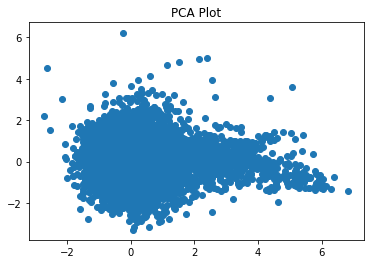

In [12]:
import matplotlib.pyplot as plt
from gensim.models import word2vec
import logging
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

model = word2vec.Word2Vec.load(skipgramfile)
vocab_list = list(model.wv.vocab.keys())

X = model.wv[vocab_list]
print("There are {} unique words".format(len(X)))

pca = PCA(n_components=2)
Bt = pca.fit(X).transform(X)

plt.figure(0)
plt.title("PCA Plot")
plt.scatter(Bt[:, 0], Bt[:, 1])
plt.show()   

看來是一個彗星的形狀。不知道是幸運星還是掃把星。

------

接下來看看tSNE的結果。

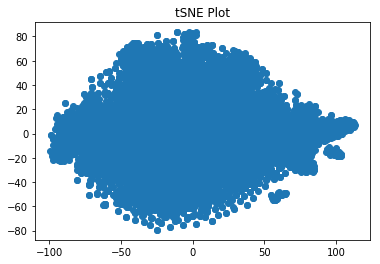

In [13]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
Yt = tsne_model.fit_transform(X)
plt.figure(1)
plt.title("tSNE Plot")
plt.scatter(Yt[:, 0], Yt[:, 1])
plt.show()   

看來也是一坨.... 應該要近一點看比較有意思。就以'獸'為中心看看吧。

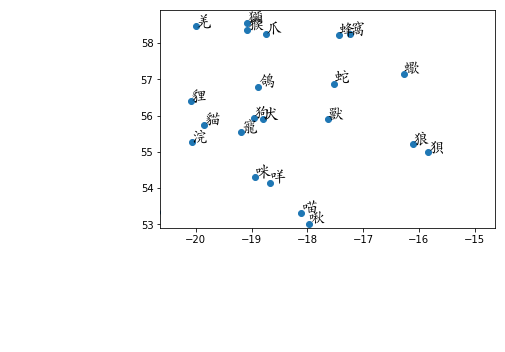

In [14]:
from matplotlib.font_manager import FontProperties
ChineseFont2 = FontProperties(fname = '/usr/share/fonts/truetype/arphic/ukai.ttc')

fig, ax = plt.subplots()
ax.scatter(Yt[:, 0], Yt[:, 1])

for i, txt in enumerate(vocab_list):
    ax.annotate(txt, (Yt[i][0],Yt[i][1]), fontsize = 16, fontproperties = ChineseFont2)

    
seed_ind = vocab_list.index('獸')
seed_pos = Yt[seed_ind]

half_width = 3
half_height = 3

plt.xlim(seed_pos[0] - half_width, seed_pos[0] + half_width)
plt.ylim(seed_pos[1] - half_height, seed_pos[1] + half_height)
plt.show()

看來周邊都是些狗、貓、蛇之輩。應該還算是合理吧。

-----------

接下來看看顏色的字有沒有物以類聚。

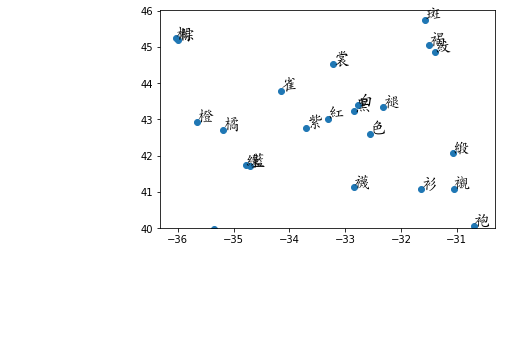

In [15]:
fig, ax = plt.subplots()
ax.scatter(Yt[:, 0], Yt[:, 1])

for i, txt in enumerate(vocab_list):
    ax.annotate(txt, (Yt[i][0],Yt[i][1]), fontsize = 16, fontproperties = ChineseFont2)

    
seed_ind = vocab_list.index('紅')
seed_pos = Yt[seed_ind]

half_width = 3
half_height = 3

plt.xlim(seed_pos[0] - half_width, seed_pos[0] + half_width)
plt.ylim(seed_pos[1] - half_height, seed_pos[1] + half_height)
plt.show()

看來還可以。紅的週邊是紫、黑、白之類的。不過也有一些奇怪的字，比如說袍之類的。

-----
來看看姓名的常用字，'怡'，

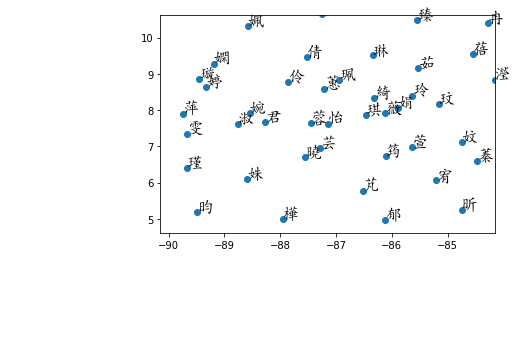

In [16]:
fig, ax = plt.subplots()
ax.scatter(Yt[:, 0], Yt[:, 1])

for i, txt in enumerate(vocab_list):
    ax.annotate(txt, (Yt[i][0],Yt[i][1]), fontsize = 16, fontproperties = ChineseFont2)

    
seed_ind = vocab_list.index('怡')
seed_pos = Yt[seed_ind]

half_width = 3
half_height = 3

plt.xlim(seed_pos[0] - half_width, seed_pos[0] + half_width)
plt.ylim(seed_pos[1] - half_height, seed_pos[1] + half_height)
plt.show()

怡的附近的確都是些女性名子的常用字。這樣就比較放心了。

---------
不知道常用的姓氏表現如何。來看看'陳'

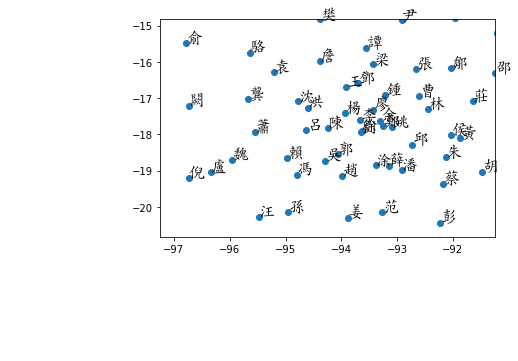

In [17]:
fig, ax = plt.subplots()
ax.scatter(Yt[:, 0], Yt[:, 1])

for i, txt in enumerate(vocab_list):
    ax.annotate(txt, (Yt[i][0],Yt[i][1]), fontsize = 16, fontproperties = ChineseFont2)

    
seed_ind = vocab_list.index('陳')
seed_pos = Yt[seed_ind]

half_width = 3
half_height = 3

plt.xlim(seed_pos[0] - half_width, seed_pos[0] + half_width)
plt.ylim(seed_pos[1] - half_height, seed_pos[1] + half_height)
plt.show()

陳的附近的確是一大堆常用姓氏。也許這個Skip-gram還真的有點用吧。